In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from itertools import cycle
from itertools import product

from scipy import stats

from googletrans import Translator

%matplotlib inline

In [27]:
#Read in .csv files into pandas dataframes
train       = pd.read_csv('sales_train.csv')
test        = pd.read_csv('test.csv').set_index('ID')
submission  = pd.read_csv('sample_submission.csv')
items       = pd.read_csv('items.csv')
item_cats   = pd.read_csv('item_categories.csv')
shops       = pd.read_csv('shops.csv')
shops_t     = pd.read_csv('shops_translated.csv')
items_t     = pd.read_csv('items_translated_text.csv')
train_lag   = pd.read_csv('month_lag_grouped.csv')
train_lag_new = pd.read_csv('new_month_group.csv')

In [257]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [290]:
def get_z_list(shop_id_num, item_id_num):
    
    item_cat = items.loc[items['item_id'] == item_id_num, ['item_category_id']].values[0][0]
    prices = train.loc[train['item_id'] == item_id_num, ['item_price']].values
    price = (stats.mode(prices))[0][0][0]
    z = ['month 34', 'shop ' + str(shop_id_num), 'item_category ' + str(item_cat), 'item ' + str(item_id_num), price]
    return z

In [291]:
print(get_z_list(55,492))

['month 34', 'shop 55', 'item_category 76', 'item 492', 600.0]


In [295]:
item_cat = items.loc[items['item_id'] == 492, ['item_category_id']].values[0][0]

In [296]:
item_cat

76

In [309]:
item_cat = items[items['item_id'] == 492]['item_category_id'].values[0]

In [310]:
item_cat

76

In [315]:
prices = train.loc[train['item_id'] == 492, ['item_price']].values
price = (stats.mode(prices))

In [321]:
price[0][0][0]

600.0

In [28]:
#Down casts the data entries from int64 to int32 and float64 to float32
#This reduces the size of the records by almost half. (From 134mb to 61mb)
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [29]:
#Calls the downcasting function
train      = downcast_dtypes(train)
test       = downcast_dtypes(test)
submission = downcast_dtypes(submission)
items      = downcast_dtypes(items)
item_cats  = downcast_dtypes(item_cats)
shops      = downcast_dtypes(shops)
shops_t    = downcast_dtypes(shops_t)
items_t    = downcast_dtypes(items_t)
train_lag  = downcast_dtypes(train_lag)
train_lag_new = downcast_dtypes(train_lag_new)

In [30]:
#adds item id to main train dataframe and drops the string name column
train = train.merge(items_t, on='item_id')
train = train.drop(columns = 'item_name')
train = train.drop(columns = 'Unnamed: 0')

In [31]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,english_name
0,02.01.2013,0,59,22154,999.0,1.0,37,ЯВЛЕНИЕ 2012 (BD)
1,23.01.2013,0,24,22154,999.0,1.0,37,ЯВЛЕНИЕ 2012 (BD)
2,20.01.2013,0,27,22154,999.0,1.0,37,ЯВЛЕНИЕ 2012 (BD)
3,02.01.2013,0,25,22154,999.0,1.0,37,ЯВЛЕНИЕ 2012 (BD)
4,03.01.2013,0,25,22154,999.0,1.0,37,ЯВЛЕНИЕ 2012 (BD)
...,...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,1.0,40,"AH, VODEVIL, VODEVIL (rem)"
2935845,01.10.2015,33,25,7903,12198.0,1.0,15,XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...
2935846,29.10.2015,33,25,7610,2890.0,1.0,64,WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13
2935847,22.10.2015,33,25,7635,2100.0,1.0,64,WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...


In [32]:
### Exploratory Merging and graphing cell for preliminary data analysis ###

# group data by month and shop_id, return sum of items sold per shop per month
month_group = pd.DataFrame(train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum().reset_index())

# added the item_category into sales_train
#merged = pd.merge(train, items[['item_id', 'item_category_id']], on = 'item_id')

# group data by month and category_id, return sum of items sold per category per month
category_group = pd.DataFrame(train.groupby(['date_block_num', 'item_category_id'])['item_cnt_day'].sum().reset_index())

In [225]:
# plotting data for visual reference

# Plot for items sold per shop per month
fig1, axes = plt.subplots(30, 2, figsize = (18,80), sharex = True, sharey = True)
shop = 0
axis = []

for i in range(int(np.max(month_group['shop_id'])/2+1)):
    axis.append([[[],[]],[[],[]]])
    
for row in range(30):
    for col in range(2):
        for date in range(len(month_group['shop_id'])):
            if month_group['shop_id'][date] == shop:
                axis[row][col][0].append(month_group['date_block_num'][date])
                axis[row][col][1].append(month_group['item_cnt_day'][date])
        shop+=1
        
shop = 0
cycol = cycle('bgrcmk')
for row in range(30):
    for col in range(2):
        axes[row, col].plot(axis[row][col][0], axis[row][col][1], color = next(cycol))
        axes[row, col].set_title('shop ' + str(shop))
        shop += 1

Error in callback <function flush_figures at 0x000002B9A0857CA8> (for post_execute):


KeyboardInterrupt: 

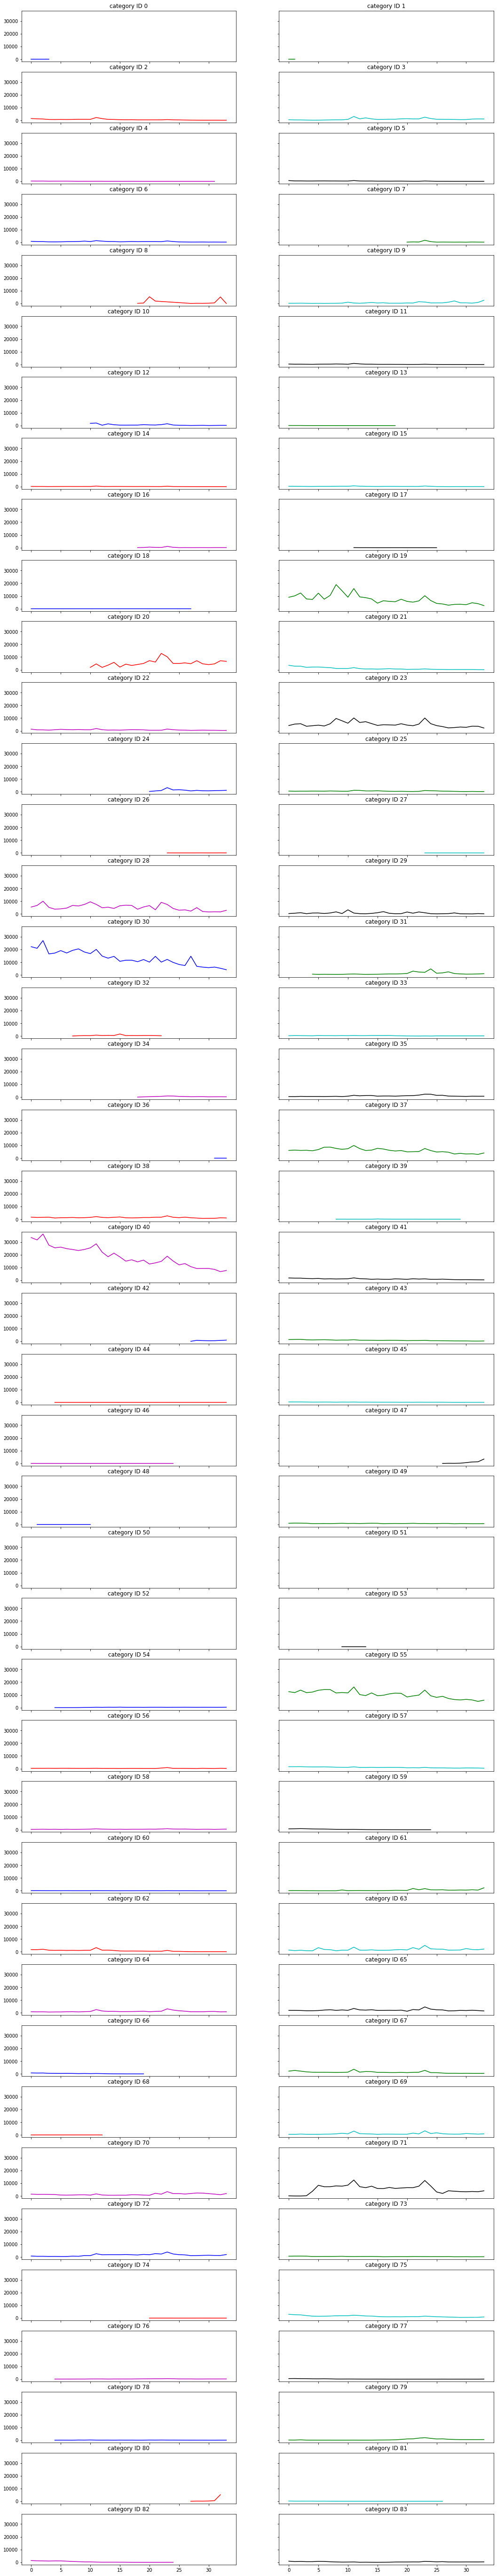

In [82]:
# plotting data for visual reference

# Plot for items sold per category per month
fig2, axes2 = plt.subplots(42, 2, figsize = (18,100), sharex = True, sharey = True)
category = 0
axis2 = []

for i in range(int(np.max(category_group['item_category_id'])/2+1)):
    axis2.append([[[],[]],[[],[]]])
    
for row in range(42):
    for col in range(2):
        for date in range(len(category_group['item_category_id'])):
            if category_group['item_category_id'][date] == category:
                axis2[row][col][0].append(category_group['date_block_num'][date])
                axis2[row][col][1].append(category_group['item_cnt_day'][date])
        category+=1
        
category = 0
cycol = cycle('bgrcmk')
for row in range(42):
    for col in range(2):
        axes2[row, col].plot(axis2[row][col][0], axis2[row][col][1], color = next(cycol))
        axes2[row, col].set_title('category ID ' + str(category))
        category += 1

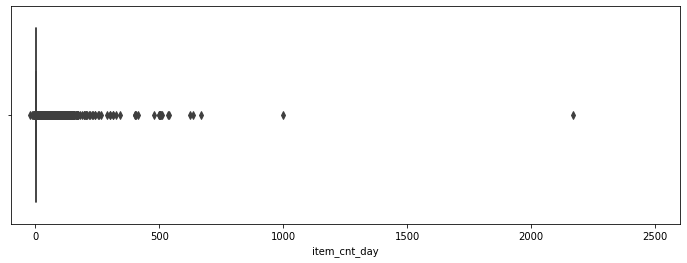

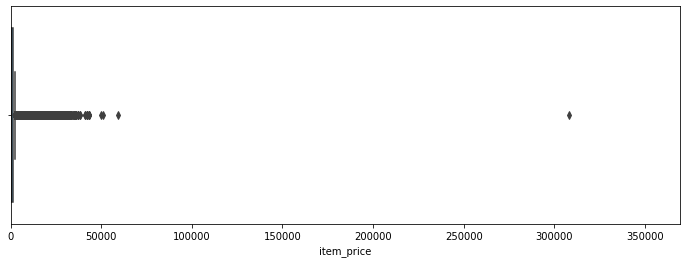

In [168]:
# Boxplot to show outliers in item_cnt_day and item_price
# This shows the outlier in price and the one instance of an unusually high sales count
plt.figure(figsize=(12,4))
plt.xlim(-100, train.item_cnt_day.max()*1.2)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(12,4))
plt.xlim(train.item_price.min()*1.1, train.item_price.max()*1.2)
sns.boxplot(x=train.item_price)

In [33]:
#Removes outliers from train
train = train[train.item_price < 90000]
train = train[train.item_cnt_day < 999]

#replaces the negative price item with the median item_price of all items with the id of 2973 and in shop id 32
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [34]:
# moves item_cnt_day to the last column
train_cnt = train['item_cnt_day']
train.drop(labels=['item_cnt_day'], axis=1, inplace = True)
train.insert(6, 'item_cnt_day', train_cnt)

In [35]:
train

,date,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day,english_name
0,02.01.2013,0,59,22154,999.0,37,1.0,ЯВЛЕНИЕ 2012 (BD)
1,23.01.2013,0,24,22154,999.0,37,1.0,ЯВЛЕНИЕ 2012 (BD)
2,20.01.2013,0,27,22154,999.0,37,1.0,ЯВЛЕНИЕ 2012 (BD)
3,02.01.2013,0,25,22154,999.0,37,1.0,ЯВЛЕНИЕ 2012 (BD)
4,03.01.2013,0,25,22154,999.0,37,1.0,ЯВЛЕНИЕ 2012 (BD)
...,...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,40,1.0,"AH, VODEVIL, VODEVIL (rem)"
2935845,01.10.2015,33,25,7903,12198.0,15,1.0,XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...
2935846,29.10.2015,33,25,7610,2890.0,64,1.0,WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13
2935847,22.10.2015,33,25,7635,2100.0,64,1.0,WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...


In [36]:
train_lag_new

,date_block_num,month,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_day
0,0,january,0,2,5572,1322.0,NaN,NaN,NaN,NaN,NaN,10.0
1,0,january,0,2,5573,560.0,NaN,NaN,NaN,NaN,NaN,1.0
2,0,january,0,2,5575,806.0,NaN,NaN,NaN,NaN,NaN,4.0
3,0,january,0,2,5576,2231.0,NaN,NaN,NaN,NaN,NaN,5.0
4,0,january,0,2,5609,2381.0,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1739017,33,october,59,79,17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1739018,33,october,59,79,17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1739019,33,october,59,83,22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1739020,33,october,59,83,22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [37]:
#new clean
#Removes outliers from train
train_lag_new = train_lag_new.dropna()
train_lag_new = train_lag_new[train_lag_new.item_price < 90000]
train_lag_new = train_lag_new[train_lag_new.item_cnt_day < 999]

#replaces the negative price item with the median item_price of all items with the id of 2973 and in shop id 32
median = train_lag_new[(train_lag_new.shop_id==32)&(train_lag_new.item_id==2973)&(train_lag_new.date_block_num==4)&(train_lag_new.item_price>0)].item_price.median()
train_lag_new.loc[train_lag_new.item_price<0, 'item_price'] = median

In [38]:
train_lag_new

,date_block_num,month,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_day
316176,5,june,2,2,5572,1490.0,2.0,2.0,1.0,1.0,4.0,2.0
316177,5,june,2,2,5573,499.0,0.0,0.0,0.0,2.0,1.0,2.0
316178,5,june,2,2,5574,499.0,0.0,2.0,2.0,3.0,0.0,1.0
316179,5,june,2,2,5575,1090.0,0.0,3.0,1.0,5.0,1.0,1.0
316180,5,june,2,2,5625,2490.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1739017,33,october,59,79,17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1739018,33,october,59,79,17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1739019,33,october,59,83,22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1739020,33,october,59,83,22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [39]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
train_lag_new['date_block_num']   = [('month ' + str(i)) for i in train_lag_new['date_block_num']]
train_lag_new['shop_id']          = [('shop ' + str(i)) for i in train_lag_new['shop_id']]
train_lag_new['item_category_id'] = [('item_category ' + str(i)) for i in train_lag_new['item_category_id']]
train_lag_new['item_id']          = [('item ' + str(i)) for i in train_lag_new['item_id']]


In [40]:
train_lag_new.reset_index(inplace=True)

In [44]:
train_lag_new = train_lag_new.drop('index', axis=1)

In [45]:
train_lag_new

,date_block_num,month,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_day
0,month 5,june,shop 2,item_category 2,item 5572,1490.0,2.0,2.0,1.0,1.0,4.0,2.0
1,month 5,june,shop 2,item_category 2,item 5573,499.0,0.0,0.0,0.0,2.0,1.0,2.0
2,month 5,june,shop 2,item_category 2,item 5574,499.0,0.0,2.0,2.0,3.0,0.0,1.0
3,month 5,june,shop 2,item_category 2,item 5575,1090.0,0.0,3.0,1.0,5.0,1.0,1.0
4,month 5,june,shop 2,item_category 2,item 5625,2490.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1422831,month 33,october,shop 59,item_category 79,item 17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1422832,month 33,october,shop 59,item_category 79,item 17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1422833,month 33,october,shop 59,item_category 83,item 22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1422834,month 33,october,shop 59,item_category 83,item 22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [46]:
x = train_lag_new.iloc[:, :-1].values
y = train_lag_new.iloc[:,-1].values

In [49]:
ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3, 4])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [51]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.506760288735727

In [228]:
#clean lag month train dataframe

# moves item_cnt_day to end
train_cnt_2 = train_lag['item_cnt_day']
train_lag.drop(labels=['item_cnt_day'], axis=1, inplace = True)
train_lag.insert(10, 'item_cnt_day', train_cnt_2)

In [229]:
#sums up daily sales into monthly sales in column item_cnt_day and renames it item_cnt_month

train_grouped_month_lag = pd.DataFrame(train_lag.groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mon_lag_1', 'mon_lag_2', 'mon_lag_3', 'mon_lag_4', 'mon_lag_5'])['item_cnt_day'].sum().reset_index())
train_grouped_month_lag.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

In [37]:
train_grouped_month_lag

,date_block_num,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_month
0,5,2,2,5572,1490.0,2.0,2.0,1.0,1.0,4.0,2.0
1,5,2,2,5573,499.0,0.0,0.0,0.0,2.0,1.0,2.0
2,5,2,2,5574,499.0,0.0,2.0,2.0,3.0,0.0,1.0
3,5,2,2,5575,1090.0,0.0,3.0,1.0,5.0,1.0,1.0
4,5,2,2,5625,2490.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1422841,33,59,79,17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1422842,33,59,79,17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1422843,33,59,83,22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1422844,33,59,83,22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [230]:
#sums up daily sales into monthly sales in column item_cnt_day and renames it item_cnt_month

train_grouped_month = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'english_name'])['item_cnt_day'].sum().reset_index())
train_grouped_month.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

In [231]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,english_name,item_cnt_month
0,0,0,2,5572,1322.0,PS Move Motion Controller (Контроллер движений...,10.0
1,0,0,2,5573,560.0,PS Move Motion Controller Charger (Зарядная ст...,1.0
2,0,0,2,5575,806.0,PS Move Sharp Shooter (Рукоятка для PS Move Co...,4.0
3,0,0,2,5576,2231.0,PS Move Starter Pack (Камера PS Eye + Контролл...,5.0
4,0,0,2,5609,2381.0,PS3/X360: Turtle Beaсh. EarForce PX21. Геймерс...,1.0
...,...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,Acceptance of funds for 1C-Online,4.0
1739015,33,59,79,17717,1999.0,Acceptance of funds for 1C-Online,1.0
1739016,33,59,83,22087,119.0,Элемент питания DURACELL LR03-BC2,6.0
1739017,33,59,83,22088,119.0,Элемент питания DURACELL LR06-BC2,2.0


In [232]:
train_grouped_month = train_grouped_month.drop('english_name', axis=1)

In [233]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,0,0,2,5572,1322.0,10.0
1,0,0,2,5573,560.0,1.0
2,0,0,2,5575,806.0,4.0
3,0,0,2,5576,2231.0,5.0
4,0,0,2,5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,4.0
1739015,33,59,79,17717,1999.0,1.0
1739016,33,59,83,22087,119.0,6.0
1739017,33,59,83,22088,119.0,2.0


In [39]:
#train_grouped_month.groupby(['item_id', 'item_price'])['item_price'].nunique().sort_values(ascending=False)

In [40]:
#train_grouped_month[train_grouped_month['shop_id']==31].head(5)

In [453]:
#def lag_feature(df, lags, col):
#    tmp = df[['date_block_num','shop_id','item_id',col]]
#    for i in lags:
#        shifted = tmp.copy()
#        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
#        shifted['date_block_num'] += i
#        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
#    return df

In [454]:
#train_grouped_month = lag_feature(train_grouped_month, [1,3,6], 'item_cnt_month')

In [455]:
#train_grouped_month.head(50)

In [415]:
#one_shop_matrix = matrix[matrix['shop_id'] == 31]
#one_shop_matrix = one_shop_matrix[one_shop_matrix['item_id'] == 17717]

In [456]:
#one_shop_matrix.sort_values('date_block_num', ascending=True).head(20)

In [234]:
#clips the sales count to 0 to 20 as per the competition evaluation metric
train_grouped_month['item_cnt_month'] = (train_grouped_month['item_cnt_month']
                                         .fillna(0)
                                         .clip(0,20) # NB clip target here
                                         .astype(np.float16))

In [99]:
train_grouped_month_lag['item_cnt_month'] = (train_grouped_month_lag['item_cnt_month']
                                             .fillna(0)
                                             .clip(0,20) # NB clip target here
                                             .astype(np.float16))

In [457]:
#train_grouped_month[train_grouped_month['item_price'] < .1].head(20)

In [458]:
#train_grouped_month.groupby(['shop_id', 'item_id', 'item_price'])['item_price'].value_counts().sort_values()

In [41]:
#train_grouped_month.groupby(['item_id'])['item_cnt_month'].value_counts().sort_values(ascending = False).head(20)

In [42]:
#train_grouped_month[train_grouped_month['item_cnt_month'] > 20].groupby(['item_id'])['item_cnt_month'].value_counts().sort_values(ascending = False).head(20)

In [43]:
#one_shop = train_grouped_month[train_grouped_month['shop_id'] == 31]
#one_shop_one_item = one_shop[one_shop['item_id'] == 20949]

In [44]:
#fig = px.scatter_matrix(one_shop_one_item,
#    dimensions=["date_block_num", "item_price", "item_cnt_month"],
#    color="item_price")
#fig.show()

In [45]:
#fig = px.scatter_matrix(one_shop,
#    dimensions=["date_block_num", "item_id", "item_price", "item_cnt_month"],
#    color="item_id")
#fig.show()

In [235]:
#count number of items that have different price changes
shops_item_price_counts = pd.DataFrame(train_grouped_month.groupby(['shop_id','item_id'])['item_price'].nunique())

In [153]:
#shops_item_price_counts = pd.DataFrame(train_grouped_month.groupby(['item_id'])['item_price'].nunique())

In [154]:
#shops_item_price_counts

In [155]:
#shops_item_price_counts[shops_item_price_counts['item_price'] > 20]

In [236]:
item_ids_less_than_10_prices = shops_item_price_counts[shops_item_price_counts['item_price'] < 10]

In [237]:
item_ids_less_than_10_prices = item_ids_less_than_10_prices.reset_index()

In [238]:
valid_items = item_ids_less_than_10_prices['item_id']

In [239]:
#item_ids_more_than_prices = shops_item_price_counts[shops_item_price_counts['item_price'] > 20]
#item_ids_more_than_prices = item_ids_more_than_10_prices.reset_index()
#valid_items_more = item_ids_more_than_prices['item_id']

In [240]:
valid_items

0            30
1            31
2            32
3            33
4            35
          ...  
421194    22154
421195    22155
421196    22162
421197    22164
421198    22167
Name: item_id, Length: 421199, dtype: int64

In [55]:
#train_grouped_month[train_grouped_month['item_cnt_month'] > 20].sort_values(by='item_cnt_month', ascending = False).head(5)

In [241]:
train_grouped_month_10_price = train_grouped_month[train_grouped_month['item_id'].isin(valid_items)]

In [57]:
#train_grouped_month_10_price[train_grouped_month_10_price['item_price'] < 50000].sort_values(by='item_cnt_month', ascending=False).head(5)

In [467]:
#train_grouped_month_10_price[train_grouped_month_10_price['item_id'] == 27]

In [58]:
#train_grouped_month_10_price = train_grouped_month_10_price[train_grouped_month_10_price['shop_id'] == 31 ]

In [242]:
train_grouped_month_10_price

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,0,0,2,5572,1322.0,10.0
1,0,0,2,5573,560.0,1.0
2,0,0,2,5575,806.0,4.0
3,0,0,2,5576,2231.0,5.0
4,0,0,2,5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,4.0
1739015,33,59,79,17717,1999.0,1.0
1739016,33,59,83,22087,119.0,6.0
1739017,33,59,83,22088,119.0,2.0


In [244]:
train_grouped_month_10_price_merged_prices = train_grouped_month_10_price.groupby(['date_block_num','shop_id','item_category_id','item_id']).agg({'item_price': 'median', 'item_cnt_month':'sum'}).reset_index()

In [133]:
#train_grouped_month_10_price = train_grouped_month_10_price.drop(['shop_id'], axis=1)

In [245]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
train_grouped_month_10_price_merged_prices['date_block_num']   = [('month ' + str(i)) for i in train_grouped_month_10_price_merged_prices['date_block_num']]
train_grouped_month_10_price_merged_prices['shop_id']          = [('shop ' + str(i)) for i in train_grouped_month_10_price_merged_prices['shop_id']]
train_grouped_month_10_price_merged_prices['item_category_id'] = [('item_category ' + str(i)) for i in train_grouped_month_10_price_merged_prices['item_category_id']]
train_grouped_month_10_price_merged_prices['item_id']          = [('item ' + str(i)) for i in train_grouped_month_10_price_merged_prices['item_id']]

In [246]:
train_grouped_month_10_price_merged_prices

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,month 0,shop 0,item_category 2,item 5572,1322.0,10.0
1,month 0,shop 0,item_category 2,item 5573,560.0,1.0
2,month 0,shop 0,item_category 2,item 5575,806.0,4.0
3,month 0,shop 0,item_category 2,item 5576,2231.0,5.0
4,month 0,shop 0,item_category 2,item 5609,2381.0,1.0
...,...,...,...,...,...,...
1608878,month 33,shop 59,item_category 75,item 5383,4390.0,1.0
1608879,month 33,shop 59,item_category 79,item 17717,500.0,13.0
1608880,month 33,shop 59,item_category 83,item 22087,119.0,6.0
1608881,month 33,shop 59,item_category 83,item 22088,119.0,2.0


In [63]:
#merged_prices

In [64]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
#merged_prices['date_block_num']   = [('month ' + str(i)) for i in merged_prices['date_block_num']]
#train_grouped_month_20_price['shop_id']          = [('shop ' + str(i)) for i in train_grouped_month_20_price['shop_id']]
#merged_prices['item_category_id'] = [('item_category ' + str(i)) for i in merged_prices['item_category_id']]
#merged_prices['item_id']          = [('item ' + str(i)) for i in merged_prices['item_id']]

In [65]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
#x = merged_prices.iloc[:, :-1].values
#y = merged_prices.iloc[:,-1].values

In [66]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

#ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
#x = ct.fit_transform(x)

In [67]:
# split data set into training set and testing set
#X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [68]:
# fitting multiple linear regression to the training set
#regressor = LinearRegression()
#regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
#y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
#regressor.score(X_test, Y_test)

In [69]:
#train_grouped_month_10_price

In [70]:
#train_grouped_month_10_price['item_id'].value_counts()

In [71]:
#fig = px.scatter_3d(merged_prices[merged_prices['item_id'] == 'item 16587'], x='date_block_num', y='item_price', z='item_cnt_month', color='item_price')
#fig.show()

In [100]:
#AUTOML CODE
#Download 64bit java
#import h2o
#from h2o.automl import H2OAutoML

#h2o.init()
#train_f3 = h2o.H2OFrame(merged_prices)

#splits3 = train_f3.split_frame(ratios = [0.8], seed = 1)
#train_split3 = splits3[0]
#test_split3 = splits3[1]

#aml3 = H2OAutoML(max_runtime_secs = 1000, seed = 1, project_name = "sales_forecasting3")
#aml3.train(y = "item_cnt_month", training_frame = train_split3, leaderboard_frame = test_split3)
#lb3 = aml3.leaderboard

In [101]:
#lb3

In [103]:
#prediction3 = aml3.leader.model_performance(test_split3)

In [102]:
#prediction3

In [72]:
#items_t[items_t['item_id'] == 11373]['english_name']

In [73]:
#items_num = 50

In [74]:
#num_items_in_shops_with_multiple_prices = []
#for x in range(0,items_num):
#    
#    num_items_in_shops_with_multiple_prices.append(len(shops_item_price_counts[shops_item_price_counts['item_price'] == x]))

In [75]:
#num_items_with_multiple_prices = pd.DataFrame(num_items_in_shops_with_multiple_prices)

In [76]:
#num_items_with_multiple_prices = num_items_with_multiple_prices.rename(columns={0:'num_items_with_x_prices'})

In [77]:
#fig = px.bar(num_items_with_multiple_prices, x=range(items_num), y='num_items_with_x_prices')
#fig.show()

In [78]:
#see which shop has most values
#train_grouped_month['shop_id'].value_counts().head()

In [79]:
#Create one dataframe for each shop
#train_one_shop_grouped_month = train_grouped_month[train_grouped_month['shop_id'] == 31]

In [80]:
#train_one_shop_grouped_month = train_one_shop_grouped_month.drop(['shop_id'], axis=1)

In [81]:
#train_one_shop_grouped_month

In [82]:
#train_one_shop_grouped_month['date_block_num']   = [('month ' + str(i)) for i in train_one_shop_grouped_month['date_block_num']]
#train_one_shop_grouped_month['item_category_id'] = [('item_category ' + str(i)) for i in train_one_shop_grouped_month['item_category_id']]
#train_one_shop_grouped_month['item_id']          = [('item ' + str(i)) for i in train_one_shop_grouped_month['item_id']]

In [247]:
train_grouped_month_10_price_merged_prices

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,month 0,shop 0,item_category 2,item 5572,1322.0,10.0
1,month 0,shop 0,item_category 2,item 5573,560.0,1.0
2,month 0,shop 0,item_category 2,item 5575,806.0,4.0
3,month 0,shop 0,item_category 2,item 5576,2231.0,5.0
4,month 0,shop 0,item_category 2,item 5609,2381.0,1.0
...,...,...,...,...,...,...
1608878,month 33,shop 59,item_category 75,item 5383,4390.0,1.0
1608879,month 33,shop 59,item_category 79,item 17717,500.0,13.0
1608880,month 33,shop 59,item_category 83,item 22087,119.0,6.0
1608881,month 33,shop 59,item_category 83,item 22088,119.0,2.0


In [248]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
x = train_grouped_month_10_price_merged_prices.iloc[:, :-1].values
y = train_grouped_month_10_price_merged_prices.iloc[:,-1].values

In [249]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [250]:
# split data set into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [251]:
# fitting multiple linear regression to the training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.30850350661150217

In [89]:
#AUTOML CODE
#Download 64bit java
#import h2o
#from h2o.automl import H2OAutoML

#h2o.init()
#train_f1 = h2o.H2OFrame(train_one_shop_grouped_month)

#splits1 = train_f1.split_frame(ratios = [0.8], seed = 1)
#train_split1 = splits[0]
#test_split1 = splits[1]

#aml1 = H2OAutoML(max_runtime_secs = 1000, seed = 1, project_name = "sales_forecasting1")
#aml1.train(y = "item_cnt_month", training_frame = train_split1, leaderboard_frame = test_split1)
#lb1 = aml1.leaderboard

In [90]:
#lb1

In [91]:
#prediction1 = aml1.leader.model_performance(test_split1)

In [92]:
#prediction1

In [8]:
#Translate entire csv frame of russian names into english
#Already done.
#def translate_and_save():
#    t = Translator()
#    items['english_name'] = items['item_name'].apply(lambda x: t.translate(x).text)
#    #shops['english_name'] = shops['shop_name'].apply(lambda x: t.translate(x).text)
#    items.to_csv('items_translated_text.csv')

In [104]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
train_grouped_month['date_block_num']   = [('month ' + str(i)) for i in train_grouped_month['date_block_num']]
train_grouped_month['shop_id']          = [('shop ' + str(i)) for i in train_grouped_month['shop_id']]
train_grouped_month['item_category_id'] = [('item_category ' + str(i)) for i in train_grouped_month['item_category_id']]
train_grouped_month['item_id']          = [('item ' + str(i)) for i in train_grouped_month['item_id']]

In [105]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,month 0,shop 0,item_category 2,item 5572,1322.0,10.0
1,month 0,shop 0,item_category 2,item 5573,560.0,1.0
2,month 0,shop 0,item_category 2,item 5575,806.0,4.0
3,month 0,shop 0,item_category 2,item 5576,2231.0,5.0
4,month 0,shop 0,item_category 2,item 5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,month 33,shop 59,item_category 79,item 17717,1250.0,4.0
1739015,month 33,shop 59,item_category 79,item 17717,1999.0,1.0
1739016,month 33,shop 59,item_category 83,item 22087,119.0,6.0
1739017,month 33,shop 59,item_category 83,item 22088,119.0,2.0


In [106]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
x = train_grouped_month.iloc[:, :-1].values
y = train_grouped_month.iloc[:,-1].values

In [107]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [108]:
# split data set into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [109]:
# fitting multiple linear regression to the training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.30629092852780027

In [110]:
train_grouped_month_lag

,date_block_num,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_month
0,5,2,2,5572,1490.0,2.0,2.0,1.0,1.0,4.0,2.0
1,5,2,2,5573,499.0,0.0,0.0,0.0,2.0,1.0,2.0
2,5,2,2,5574,499.0,0.0,2.0,2.0,3.0,0.0,1.0
3,5,2,2,5575,1090.0,0.0,3.0,1.0,5.0,1.0,1.0
4,5,2,2,5625,2490.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1422841,33,59,79,17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1422842,33,59,79,17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1422843,33,59,83,22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1422844,33,59,83,22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [111]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
train_grouped_month_lag['date_block_num']   = [('month ' + str(i)) for i in train_grouped_month_lag['date_block_num']]
train_grouped_month_lag['shop_id']          = [('shop ' + str(i)) for i in train_grouped_month_lag['shop_id']]
train_grouped_month_lag['item_category_id'] = [('item_category ' + str(i)) for i in train_grouped_month_lag['item_category_id']]
train_grouped_month_lag['item_id']          = [('item ' + str(i)) for i in train_grouped_month_lag['item_id']]


In [112]:
train_grouped_month_lag

,date_block_num,shop_id,item_category_id,item_id,item_price,mon_lag_1,mon_lag_2,mon_lag_3,mon_lag_4,mon_lag_5,item_cnt_month
0,month 5,shop 2,item_category 2,item 5572,1490.0,2.0,2.0,1.0,1.0,4.0,2.0
1,month 5,shop 2,item_category 2,item 5573,499.0,0.0,0.0,0.0,2.0,1.0,2.0
2,month 5,shop 2,item_category 2,item 5574,499.0,0.0,2.0,2.0,3.0,0.0,1.0
3,month 5,shop 2,item_category 2,item 5575,1090.0,0.0,3.0,1.0,5.0,1.0,1.0
4,month 5,shop 2,item_category 2,item 5625,2490.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1422841,month 33,shop 59,item_category 79,item 17717,1250.0,1.0,1.0,4.0,2.0,1.0,4.0
1422842,month 33,shop 59,item_category 79,item 17717,1999.0,1.0,1.0,4.0,2.0,1.0,1.0
1422843,month 33,shop 59,item_category 83,item 22087,119.0,3.0,2.0,5.0,1.0,2.0,6.0
1422844,month 33,shop 59,item_category 83,item 22088,119.0,1.0,7.0,7.0,4.0,3.0,2.0


In [113]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
x = train_grouped_month_lag.iloc[:, :-1].values
y = train_grouped_month_lag.iloc[:,-1].values

In [114]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [115]:
# split data set into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [116]:
# fitting multiple linear regression to the training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.32302038164064206

In [381]:
#0.24532067463255935
#0.24591807973656044

In [48]:
# This is for playing around with different items and shops 
# sample format of test prediction = ['month 0', 'shop 0', 'item_category 2', 'item 5572', 1322]

# A simple program to see how the predictor would work

#from scipy import stats
#def auto_predictor():
#    global ct
#    month = input('Please enter the month you want to predict. Enter the digit of the month, eg. Jan = 0 : ')
#    shop = input('Please enter the shop ID, eg. 2 : ')
#    item = input("Please enter the item ID you wish to predict, eg. for item 55, enter '55' : ")
#    item_cat = (items.loc[items['item_id'] == int(item), ['item_category_id']].values)[0][0]
#    prices = train.loc[train['item_id'] == int(item), ['item_price']].values
#    price = (stats.mode(prices))[0][0][0]
    
#    z = ['month ' + str(month), 'shop ' + str(shop), 'item_category ' + str(item_cat), 'item ' + str(item), price]
#    z = np.array(z, dtype = object).reshape(1, -1)
#    z = ct.transform(z)
#    z_pred = regressor.predict(z)
    
#    return(z_pred[0])

# Things to check!!!
# ***There are multiple prices available for the item in that specific shop, provide an option to choose price

In [117]:
#AUTOML CODE
#Download 64bit java
import h2o
from h2o.automl import H2OAutoML

h2o.init()
train_f = h2o.H2OFrame(train_grouped_month)

splits = train_f.split_frame(ratios = [0.8], seed = 1)
train_split = splits[0]
test_split = splits[1]

aml = H2OAutoML(max_runtime_secs = 1000, seed = 1, project_name = "sales_forecasting")
aml.train(y = "item_cnt_month", training_frame = train_split, leaderboard_frame = test_split)
lb = aml.leaderboard

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\Cooper\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Cooper\AppData\Local\Temp\tmpldidcg5m
  JVM stdout: C:\Users\Cooper\AppData\Local\Temp\tmpldidcg5m\h2o_Cooper_started_from_python.out
  JVM stderr: C:\Users\Cooper\AppData\Local\Temp\tmpldidcg5m\h2o_Cooper_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Cooper_r2kmcn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.547 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
19:27:07.698: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [118]:
#shows leaderboard of model competition
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200921_192707,3.35659,1.8321,3.35659,0.930339,0.363215
StackedEnsemble_BestOfFamily_AutoML_20200921_192707,3.46243,1.86076,3.46243,0.948145,0.36991
DRF_1_AutoML_20200921_192707,3.60945,1.89985,3.60945,0.970267,0.36573
GBM_grid__1_AutoML_20200921_192707_model_2,3.67932,1.91816,3.67932,0.978928,0.372636
GBM_4_AutoML_20200921_192707,3.87988,1.96974,3.87988,1.02164,0.377739
GBM_5_AutoML_20200921_192707,3.89311,1.9731,3.89311,1.02638,0.369855
GBM_3_AutoML_20200921_192707,4.07908,2.01967,4.07908,1.04134,0.388926
GBM_2_AutoML_20200921_192707,4.18262,2.04515,4.18262,1.05155,0.393572
GBM_1_AutoML_20200921_192707,4.28339,2.06964,4.28339,1.06283,0.398934
GLM_1_AutoML_20200921_192707,4.434,2.10571,4.434,1.08796,0.406016


In [120]:
prediction = aml.leader.model_performance(test_split)

In [121]:
prediction


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 3.3565863928657813
RMSE: 1.8320989036800883
MAE: 0.9303388377915874
RMSLE: 0.3632152876864714
R^2: 0.4106659680719166
Mean Residual Deviance: 3.3565863928657813
Null degrees of freedom: 347712
Residual degrees of freedom: 347709
Null deviance: 1980420.2900689985
Residual deviance: 1167128.7244225394
AIC: 1407830.9401176944


In [122]:
h2o.init()
train_lag = h2o.H2OFrame(train_grouped_month_lag)

splits_lag = train_lag.split_frame(ratios = [0.8], seed = 1)
train_split_lag = splits_lag[0]
test_split_lag = splits_lag[1]

aml_lag = H2OAutoML(max_runtime_secs = 1000, seed = 1, project_name = "sales_forecasting_lag")
aml_lag.train(y = "item_cnt_month", training_frame = train_split_lag, leaderboard_frame = test_split_lag)
lb_lag = aml_lag.leaderboard

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 mins 35 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Cooper_r2kmcn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.073 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█
19:47:01.78: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


In [123]:
lb_lag

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200921_194701,3.15433,1.77604,3.15433,0.888956,0.348788
StackedEnsemble_AllModels_AutoML_20200921_194701,3.15464,1.77613,3.15464,0.888777,0.34873
GBM_grid__1_AutoML_20200921_194701_model_2,3.21642,1.79344,3.21642,0.90591,0.350722
DRF_1_AutoML_20200921_194701,3.36769,1.83513,3.36769,0.917202,0.353516
GBM_4_AutoML_20200921_194701,3.52477,1.87744,3.52477,0.97274,0.359893
GBM_3_AutoML_20200921_194701,3.5422,1.88207,3.5422,0.962663,0.361906
GBM_2_AutoML_20200921_194701,3.64711,1.90974,3.64711,0.97329,0.366557
GBM_5_AutoML_20200921_194701,3.67484,1.91699,3.67484,0.999655,0.361551
GBM_1_AutoML_20200921_194701,3.67843,1.91792,3.67843,0.97237,0.368328
GBM_grid__1_AutoML_20200921_194701_model_1,3.77793,1.94369,3.77793,0.979449,0.374444


In [124]:
prediction_lag = aml_lag.leader.model_performance(test_split_lag)

In [125]:
prediction_lag


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 3.1543345323247665
RMSE: 1.7760446312873914
MAE: 0.8889564855061316
RMSLE: 0.3487881852815309
R^2: 0.4496461998362392
Mean Residual Deviance: 3.1543345323247665
Null degrees of freedom: 284443
Residual degrees of freedom: 284441
Null deviance: 1630290.1538631679
Residual deviance: 897231.5317125858
AIC: 1133987.9854161697
